In [208]:
import pandas as pd
from tqdm import tqdm
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
import numpy as np
import matplotlib.animation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json

spacy.prefer_gpu()
tqdm.pandas()

STOPWORDS = set(stopwords.words('russian'))

NER = spacy.load("ru_core_news_lg")

In [241]:
def get_fwd_name(id, original_df, links_df):
    res = original_df[original_df.peer_id == id].chat
    if len(res) < 1:
        res = links_df[links_df.id == id].chat_name
        if len(res) < 1:
            return None
        else:
            return res.values[0]
    else:
        return res.values[0]
    

def ner_message(x):
    return [[ent.text for ent in sent.ents if ent.label_ == 'PER'] for sent in NER(x).sents]

def total_interactions(x):
    reactions_total = 0
    for _, value in json.loads(x.replace("'", '"')).items():
        reactions_total += value
    return reactions_total

def weighted_popularity_score(row):
    return np.mean([row.views, row.forwards, row.reaction_nb])

def min_max_normalization(col, df):
    return (df[col]-df[col].min())/(df[col].max()-df[col].min())

def remove_stopwords(m):
    word_tokens = word_tokenize(m)
    return ' '.join([w for w in word_tokens if not w.lower() in STOPWORDS])
        

In [210]:
messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')
messages['messageDateTime'] = messages['messageDate'].astype('datetime64[ns]')
messages['year_month'] = messages['messageDateTime'].dt.strftime('%Y_%m')
messages['chat'] = messages.chat.progress_apply(lambda x: x.replace('https://t.me/', ''))

# Add popularity score
messages['reaction_nb'] = messages.reactions.apply(lambda x: total_interactions(x))
messages["views_norm"] = min_max_normalization("views", messages)
messages["forwards_norm"] = min_max_normalization("forwards", messages)
messages["reaction_nb_norm"] = min_max_normalization("reaction_nb", messages)
messages['popularity_score'] = messages.apply(lambda x: weighted_popularity_score(x), axis=1)

/var/folders/fb/v6scng3j5lbcmnb3mjn82zhr0000gn/T/ipykernel_19011/3196547777.py:1: DtypeWarning: Columns (24,25,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')
100%|██████████| 1623145/1623145 [00:00<00:00, 2255251.43it/s]


In [211]:
sololiev_chat = messages[messages.chat == 'SolovievLive']

In [213]:
docs = []
for time_frame in tqdm(list(sololiev_chat.year_month.unique())):
    top_daily_messages = list(sololiev_chat[sololiev_chat.year_month == time_frame].sort_values('popularity_score',ascending = False).head(50).messageText.values)
    docs.append({
        'messages': top_daily_messages,
        'document': '\n'.join(top_daily_messages),
        'frame': time_frame
    })
print(len(docs))
docs[0]

100%|██████████| 65/65 [00:00<00:00, 80.43it/s]

65


{'messages': ['Если бы этого дела не было, оппозиции надо было бы его выдумать. Решается сразу несколько задач. \n\nВо-первых, обеляет свою репутацию Медуза, сильно подмоченную сексуальным скандалом и тем, как Тимченко попыталась из него выйти. \n\nВо-вторых, забивается тема «Соболь против Симоньян». Уже никому неинтересно, что произошло на Эхо Москвы, кто виноват, как самочувствие беременной Маргариты - все уже неважно, все в прошлом, и инцидент, полностью уничтожающий репутацию Соболь, перестает занимать первые строчки в новостной ленте. \n\nВ-третьих, демонстрируется возможность собрать активистов и устроить информационный вал в СМИ, скажем вежливо, настроенных на одну волну, с подключением иностранных как общественных, так и государственных структур, которые умудрились не видя материалов дела прийти к выводу о виновности или невиновности журналиста. \n\nНе могу не отметить несколько пикантных моментов. С какой готовностью телеграмм каналы подхватили версию, что за провокацией проти

In [242]:
from itertools import combinations
edge_list = []

for doc in tqdm(docs):
    entities = ner_message(doc['document'])
    for sentence_entities in entities:
        if len(sentence_entities)>1:
            edge_list.extend(combinations(sentence_entities, 2))

100%|██████████| 65/65 [00:32<00:00,  2.01it/s]


In [244]:
print(len(edge_list))

9943


In [245]:
import re 
from transliterate import translit

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" #emotions
                           u"\U0001F300-\U0001F5FF" #sumbols and pictographs
                           u"\U0001F680-\U0001F6FF" #transport and map symbols
                           u"\U0001F1E0-\U0001F1FF" #flags
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251" 

                           "]+",flags = re.UNICODE)

edges = pd.DataFrame(edge_list, columns=['source', 'target'])
edges.source = edges.source.apply(lambda x: emoji_pattern.sub(r'', x))
edges.target = edges.target.apply(lambda x: emoji_pattern.sub(r'', x))
print(edges)
edges.source = edges.source.apply(lambda x: translit(x, 'ru', reversed=True))
edges.target = edges.target.apply(lambda x: translit(x, 'ru', reversed=True))
print(edges)
count_series = edges.groupby(['source', 'target']).size()
edges = count_series.to_frame(name = 'value').reset_index()
edges = edges[(edges['source'].str.len() > 1) & (edges['target'].str.len() > 1)]
edges

          source    target
0         Медуза  Тимченко
1      Маргариты    Соболь
2         Медузы  Голунова
3          Ивана  Мясников
4          Ивана    Путина
...          ...       ...
9938         Рэп    Иссуфф
9939  Мессье Яро    Иссуфф
9940      Джокер      Маск
9941      Джокер        Х.
9942        Маск        Х.

[9943 rows x 2 columns]
           source     target
0          Meduza  Timchenko
1       Margarity     Sobol'
2          Meduzy   Golunova
3           Ivana  Mjasnikov
4           Ivana     Putina
...           ...        ...
9938          Rep     Issuff
9939  Mess'e Jaro     Issuff
9940      Dzhoker       Mask
9941      Dzhoker         H.
9942         Mask         H.

[9943 rows x 2 columns]


,source,target,value
15,Telekanal,Naval'nogo,1
16,Telekanal,Smotrim,9
17,A.-H. Kadyrova,Ahmata-Hadzhi Kadyrova,1
18,A.Naval'nogo,Pavlu Zarubinu,1
19,Abbas Dzhuma,Telekanal,1
...,...,...,...
6909,Zolotov Viktor Vasil'evich,Kochnev Dmitrij Viktorovich,1
6910,Zolotovu,Ilon Mask,1
6911,Zolotovu,Sergej Kirienko,1
6912,donchanina,Aleksandra Semchenko,1


In [250]:
search_depth = 2
search_nodes = ['Putina']

for i in range(search_depth-1):
    level = edges[edges.source.isin(search_nodes)]
    search_nodes.extend(list(set(level.source.values.tolist())))
    search_nodes.extend(list(set(level.target.values.tolist())))

edges_test = edges[edges.source.isin(search_nodes)]
edges_test

,source,target,value
76,Aleksandr Dobrovinskij,Aleksandr Dobrovinskij,1
77,Aleksandr Dobrovinskij,Aleksandr Kots,3
78,Aleksandr Dobrovinskij,Aleksandr Mjasnikov,1
79,Aleksandr Dobrovinskij,Aleksandr Sosnovskij,1
80,Aleksandr Dobrovinskij,Aleksandra Lukashenko,1
...,...,...,...
6879,Zelenskogo,Sentsova,1
6880,Zelenskogo,Sergej Karnauhov,1
6881,Zelenskogo,Shufrich,1
6882,Zelenskogo,Solov'ev,1


In [251]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(
    edges_test,
    source='source',
    target='target',
    edge_attr='value',
    create_using=nx.Graph()
)

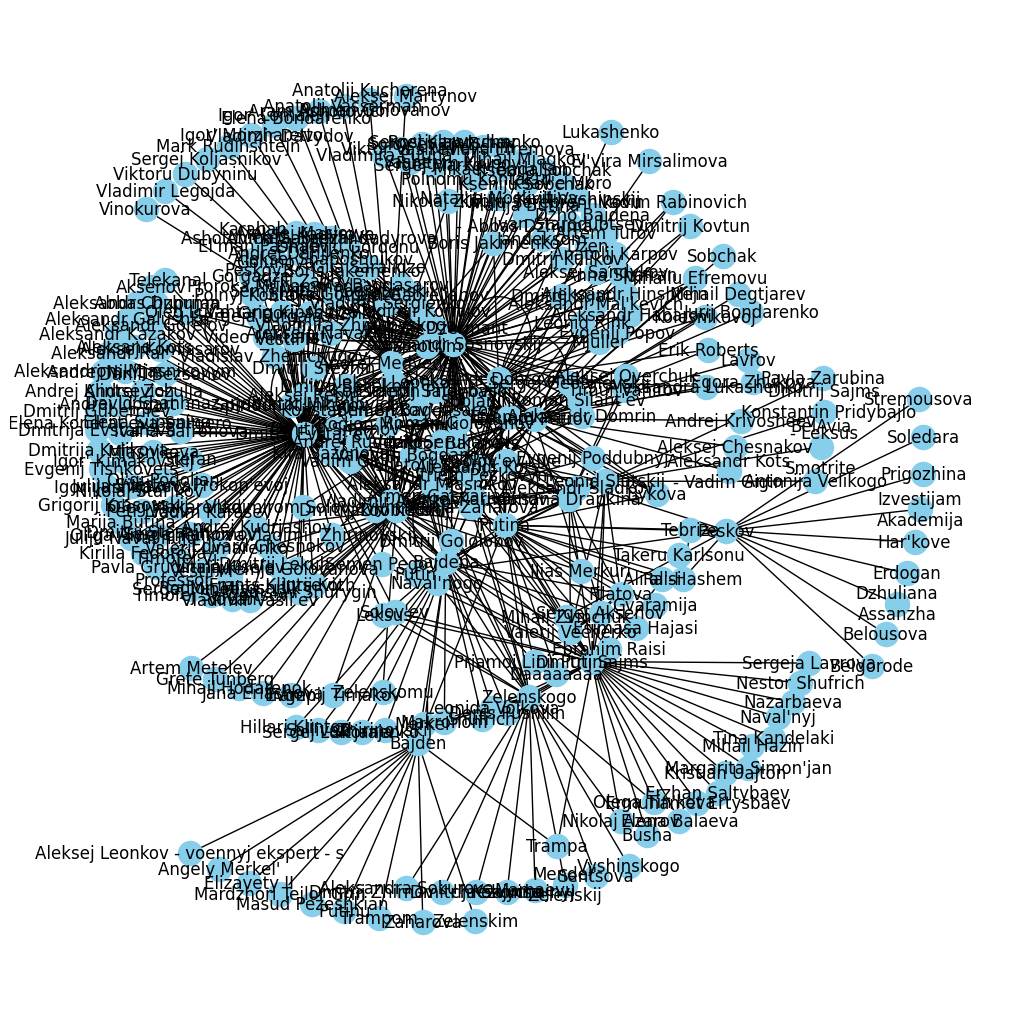

In [254]:
import community as community_louvain

communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', arrowsize=10, arrows=True, edge_cmap=plt.cm.Blues)

net = Network(notebook=True, width='100wh', height='100vh', bgcolor='#222222', font_color='white')
net.from_nx(G)

degree_nodes = dict(G.degree)
nx.set_node_attributes(G, degree_nodes, 'size')

net.toggle_physics(False)
net.show_buttons(filter_=['physics'])
net.save_graph('entities.html')